<a href="https://colab.research.google.com/github/saparbayev-azizbek-12/bi-and-ai-talents-dl/blob/main/lesson-17/Conv_For_Sentence_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sentence Classification Examples:

    1. Sentiment Analysis
        1.1 Positive
        1.2 Negative
        I really hate this music -> Negative -> 0
        I love this food -> Positive -> 1
    2. Jumla qaysi tilda yozilganini aniqlash
    3. Names dataset classification
    


In [1]:
%%capture
!pip install unidecode

In [2]:
import torch
from google.colab import drive

drive.mount("/drive")

Mounted at /drive


In [3]:
from unidecode import unidecode

In [4]:
!ls /drive/MyDrive/names

Arabic.txt   English.txt  Irish.txt	Polish.txt	Spanish.txt
Chinese.txt  French.txt   Italian.txt	Portuguese.txt	Vietnamese.txt
Czech.txt    German.txt   Japanese.txt	Russian.txt
Dutch.txt    Greek.txt	  Korean.txt	Scottish.txt


In [5]:
import os
from glob import glob

In [6]:
root_dir = "/drive/MyDrive/names"
file_names = glob("*.txt", root_dir=root_dir)
unique_labels = sorted([os.path.splitext(file_name)[0] for file_name in file_names])
n_labels = len(unique_labels)

idx2label = {idx:label for idx, label in enumerate(unique_labels)}
label2idx = {label:idx for idx, label in idx2label.items()}

In [7]:
def replace(name, chars, target):
    for char in chars:
        name = name.replace(char, target)
    return name

In [8]:
X_names = []
Y_labels = []

for file_name in file_names:
    with open(os.path.join(root_dir, file_name), "rt", encoding='utf-8') as f:
        for line in f:
            name = line.strip().lower()
            name = unidecode(name)

            if name == 'to the first page':
                continue

            name = replace(name, [",", '1', "/b", ":", "\xa0"], '')
            name = replace(name, ['-'], ' ')

            X_names.append(name)
            Y_labels.append(os.path.splitext(file_name)[0])

1. Remove "To The First Page" names from dataset
2. Replace ",", '1', "/B", ":", \xa0 with empty string
3. Replace '-' with ' '
4. Convert all the following from unicode to ascii:
[ 'ß',
 'à',
 'á',
 'ã',
 'ä',
 'ç',
 'è',
 'é',
 'ê',
 'ì',
 'í',
 'ñ',
 'ò',
 'ó',
 'õ',
 'ö',
 'ù',
 'ú',
 'ü',
 'ą',
 'ł',
 'ń',
 'ś',
 'ż']

In [9]:
pad_token = '.'
pad_token_id = 0

unique_chars = [pad_token] + sorted(set(''.join(X_names)))
idx2char = {idx:char for idx, char in enumerate(unique_chars)}
char2idx = {char:idx for idx, char in idx2char.items()}

def encode(name: str) -> list[int]:
    return [char2idx[char] for char in name]

def decode(ids: list[int]) -> str:
    return ''.join(idx2char[i] for i in ids)

In [10]:
Y = [label2idx[label] for label in Y_labels]
X = [encode(name) for name in X_names]

In [11]:
for x, x_name, y, y_label in zip(X[:5], X_names[:5], Y[:5], Y_labels[:5]):
    print(f"{str(x):<35} -> {x_name:<10} {y} -> {y_label}")

[3, 4, 4, 11, 16, 9]                -> abbing     6 -> German
[3, 4, 7, 14]                       -> abel       6 -> German
[3, 4, 7, 14, 16]                   -> abeln      6 -> German
[3, 4, 22]                          -> abt        6 -> German
[3, 5, 10, 11, 14, 14, 7, 21]       -> achilles   6 -> German


1. Split data into train and test
2. NamesDataset for both train and test
3. Data Loader for both train and test with custom `collate` function

In [12]:
from sklearn.model_selection import  train_test_split

In [13]:
Xtr, Xts, Ytr, Yts = train_test_split(X, Y, test_size=0.2, stratify=Y)

In [14]:
from torch.utils.data import Dataset, DataLoader

class NamesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

Dtr = NamesDataset(Xtr, Ytr)
Dts = NamesDataset(Xts, Yts)

In [15]:
global_max_n = 20

def collate_fn(batch):
    x, y = zip(*batch)
    max_n = max(len(row) for row in x)
    max_n = global_max_n if max_n > global_max_n else max_n
    x_padded = torch.zeros(len(x), max_n, dtype=torch.long)

    for i in range(len(x)):
        x_padded[i, :len(x[i])] = torch.tensor(x[i][:max_n])

    return x_padded, torch.tensor(y, dtype=torch.long)


Dltr = DataLoader(Dtr, batch_size=4, shuffle=True, drop_last=True, collate_fn=collate_fn)
Dlts = DataLoader(Dts, batch_size=4, shuffle=False, drop_last=False, collate_fn=collate_fn)

In [16]:
idx2label

{0: 'Arabic',
 1: 'Chinese',
 2: 'Czech',
 3: 'Dutch',
 4: 'English',
 5: 'French',
 6: 'German',
 7: 'Greek',
 8: 'Irish',
 9: 'Italian',
 10: 'Japanese',
 11: 'Korean',
 12: 'Polish',
 13: 'Portuguese',
 14: 'Russian',
 15: 'Scottish',
 16: 'Spanish',
 17: 'Vietnamese'}

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass

class  NamesClassifier(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.emb = nn.Embedding(self.config.vocab_size, self.config.n_embd) # B, T, C
        self.conv = nn.Conv1d(self.config.n_embd, self.config.n_conv_channels, self.config.kernel_size)

        self.max_pool = nn.AdaptiveMaxPool1d(1)
        self.drop = nn.Dropout(self.config.drop_rate)
        self.fc = nn.Linear(self.config.n_conv_channels, self.config.n_labels)
        self.cr = F.cross_entropy

    def forward(self, x):
        # print("initial:", x.size()) # (4, 11)
        x = self.emb(x) # B, T, C
        # print("emb:", x.size()) # (4, 11, 16)
        x = x.permute(0, 2, 1) # B, C, T
        # print("permute:", x.size()) #(4, 16, 11)
        x = self.conv(x)
        # print("conv:", x.size()) #(4, 32, 9)
        x = self.max_pool(x)
        # print("max_pool:", x.size())  #(4, 32, 1)
        x = self.drop(x.squeeze(-1))
        # print("squeeze:", x.size()) # (4, 32)
        x = self.fc(x)
        # print("linear:", x.size()) # (4, 18)
        return x

    def loss(self, x, y):
        x = self.forward(x)
        return self.cr(x, y)

@dataclass
class Config:
    vocab_size: int
    n_embd: int
    n_conv_channels: int
    kernel_size: int
    drop_rate: float
    n_labels: int

config = Config(vocab_size=29, n_embd=16, n_conv_channels=32, kernel_size=3, drop_rate=0.5, n_labels=18)
model = NamesClassifier(config)

# Homework

In [61]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    lossi = 0
    for x_batch, y_batch in Dltr:
        optimizer.zero_grad()
        loss = model.loss(x_batch, y_batch)
        loss.backward()
        optimizer.step()
        lossi += loss.item()
    print(f"Epoch: {epoch + 1}: Loss: {(lossi/len(Dltr)):.4f}")

Epoch: 0: Loss: 0.9474
Epoch: 1: Loss: 0.9427
Epoch: 2: Loss: 0.9463
Epoch: 3: Loss: 0.9412
Epoch: 4: Loss: 0.9357
Epoch: 5: Loss: 0.9355
Epoch: 6: Loss: 0.9354
Epoch: 7: Loss: 0.9340
Epoch: 8: Loss: 0.9209
Epoch: 9: Loss: 0.9296


In [ ]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x, y in Dlts:
        logits = model.forward(x)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.tolist())
        all_labels.extend(y.tolist())

model.train()

In [51]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7472


<Figure size 1600x1400 with 0 Axes>

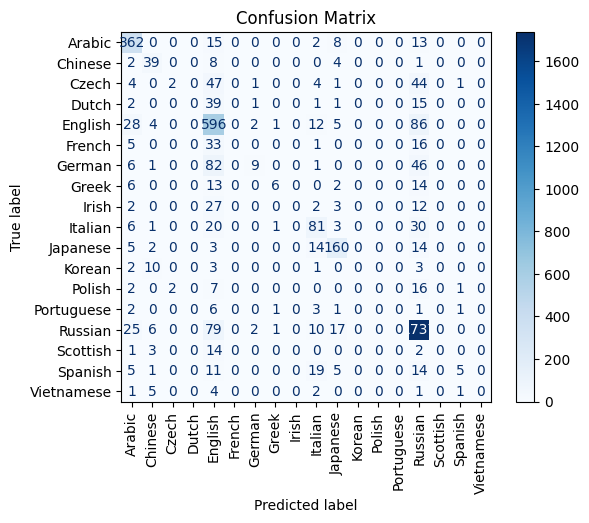

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(16, 14))
display = ConfusionMatrixDisplay(conf_matrix, display_labels=[idx2label[i] for i in sorted(idx2label.keys())])
display.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()
